# Predicción de Series Temporales NN - Embeddings

### Usaremos Keras y Tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


### Cargamos nuestro Dataset

In [2]:
df = pd.read_csv('Prueba_Id.csv', parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2018-05-23,3
2018-05-25,3
2018-05-29,2
2018-06-08,1
2018-06-11,2


In [3]:
print(df.index.min())
print(df.index.max())

2018-05-23 00:00:00
2019-06-21 00:00:00


In [4]:
print(len(df['2018']))
print(len(df['2019']))

125
145


### Cargamos Datos Categóricos: Día y Mes

In [5]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2018-05-23,3,2,5
2018-05-25,3,4,5
2018-05-29,2,1,5
2018-06-08,1,4,6
2018-06-11,2,0,6


In [6]:
df.describe()

,unidades,weekday,month
count,270.000000,270.000000,270.000000
mean,15.111111,2.855556,5.877778
std,27.726000,1.935163,3.459251
min,1.000000,0.000000,1.000000
25%,2.000000,1.000000,3.000000
50%,5.000000,3.000000,6.000000
75%,12.750000,4.000000,9.000000
max,180.000000,6.000000,12.000000


## Preprocesado de los datos

In [7]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.977654,-0.977654,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,5.0,6.0
1,-0.977654,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,6.0,6.0
2,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,0.0,6.0
3,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307,1.0,6.0
4,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307,-0.977654,2.0,6.0


In [9]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,5.0,6.0,-0.977654,-0.977654,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000
1,6.0,6.0,-0.977654,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000
2,0.0,6.0,-0.988827,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000
3,1.0,6.0,-1.000000,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307
4,2.0,6.0,-0.988827,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307,-0.977654
5,3.0,6.0,-0.977654,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307,-0.977654,-0.910614
6,4.0,6.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.955307,-0.977654,-0.910614,-0.843575
7,6.0,6.0,-1.000000,-1.000000,-1.000000,-0.955307,-0.977654,-0.910614,-0.843575,-1.000000
8,0.0,6.0,-1.000000,-1.000000,-0.955307,-0.977654,-0.910614,-0.843575,-1.000000,-0.977654
9,1.0,6.0,-1.000000,-0.955307,-0.977654,-0.910614,-0.843575,-1.000000,-0.977654,0.888268


## Dividimos en set de Entrenamiento y Validación

In [10]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[261-30:261]
valid_target=target_data[261-30:261]

training_data = training_data[0:261]
target_data=target_data[0:261]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(261, 9) (261,) (30, 9) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward con Embeddings

#### Tenemos como entradas 9 columnas (2 embeddings y 7 pasos)

In [11]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model


## Entrenamiento y Resultados

In [12]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

W0826 01:37:18.205294  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 01:37:18.355293  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 01:37:18.363296  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 01:37:18.862286  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         16          dias[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 4)         52          meses[0][0]                      
__________________________________________________________________________________________________
concatenat

W0826 01:37:20.328268  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 01:37:21.148258  5476 deprecation_wrapper.py:119] From C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 261 samples, validate on 30 samples
Epoch 1/40
261/261 [==============================] - 12s 48ms/step - loss: 0.8551 - mean_squared_error: 0.7641 - val_loss: 0.7264 - val_mean_squared_error: 0.5985
Epoch 2/40
261/261 [==============================] - 0s 718us/step - loss: 0.7930 - mean_squared_error: 0.6597 - val_loss: 0.6617 - val_mean_squared_error: 0.5045
Epoch 3/40
261/261 [==============================] - ETA: 0s - loss: 0.7419 - mean_squared_error: 0.58 - 0s 539us/step - loss: 0.7259 - mean_squared_error: 0.5587 - val_loss: 0.5979 - val_mean_squared_error: 0.4172
Epoch 4/40
261/261 [==============================] - 0s 868us/step - loss: 0.6577 - mean_squared_error: 0.4641 - val_loss: 0.5369 - val_mean_squared_error: 0.3378
Epoch 5/40
261/261 [==============================] - 0s 539us/step - loss: 0.5890 - mean_squared_error: 0.3776 - val_loss: 0.4746 - val_mean_squared_error: 0.2662
Epoch 6/40
261/261 [==============================] - 0s 869us/step - loss: 0.5188 

## Visualizamos Resultados

30


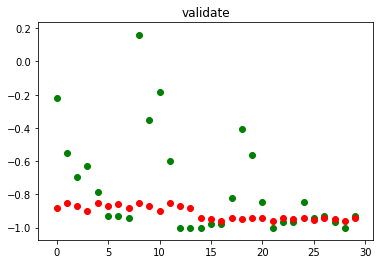

In [13]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. TIP: Si aumentamos la cantidad de EPOCHS mejora cada vez más

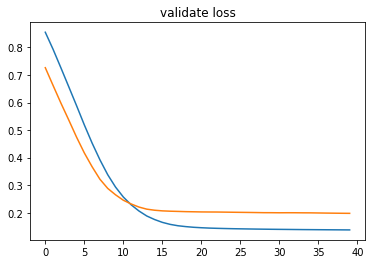

In [14]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Modelo 3) STE: En azul el Entrenamiento y naranja el set de Validación

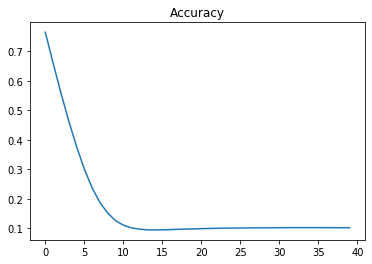

In [15]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [16]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,71.000000,11.792932,59.207069
1,41.000000,14.127082,26.872917
2,28.000002,12.843274,15.156728
3,34.000004,9.909065,24.090939
4,19.999998,14.313238,5.686760
5,6.999998,12.535056,-5.535058
6,6.999998,13.602177,-6.602179
7,6.000002,11.792932,-5.792929
8,104.999992,14.127082,90.872910
9,58.999996,12.843274,46.156723


In [17]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,22.433332,8.929277,13.504057
std,26.851677,3.658741,25.468699
min,1.000000,4.601058,-11.535056
25%,4.000001,5.803638,-3.383536
50%,6.999998,6.302123,0.735654
75%,36.250001,12.535056,23.739894
max,104.999992,14.313238,90.872910


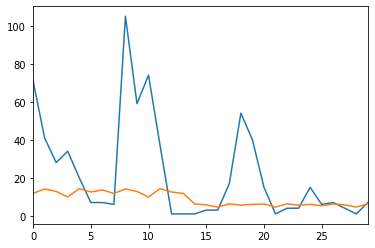

In [18]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

In [19]:
ultimosDias = df['2019-05-16':'2019-05-31']
ultimosDias

,unidades,weekday,month
fecha,,,
2019-05-16,71,3,5
2019-05-17,41,4,5
2019-05-18,28,5,5
2019-05-19,34,6,5
2019-05-20,20,0,5
2019-05-21,7,1,5
2019-05-22,7,2,5
2019-05-23,6,3,5
2019-05-24,105,4,5


## Preparamos los datos para Test

Y ahora seguiremos el mismo preprocesado de datos que hicimos para el entrenamiento: escalando los valores, llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida «Y» pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [20]:
# load dataset
values = ultimosDias['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,4.0,5.0,0.346154,-0.230769,-0.480769,-0.365385,-0.634615,-0.884615,-0.884615
1,5.0,5.0,-0.230769,-0.480769,-0.365385,-0.634615,-0.884615,-0.884615,-0.903846
2,6.0,5.0,-0.480769,-0.365385,-0.634615,-0.884615,-0.884615,-0.903846,1.000000
3,0.0,5.0,-0.365385,-0.634615,-0.884615,-0.884615,-0.903846,1.000000,0.115385
4,1.0,5.0,-0.634615,-0.884615,-0.884615,-0.903846,1.000000,0.115385,0.403846
5,2.0,5.0,-0.884615,-0.884615,-0.903846,1.000000,0.115385,0.403846,-0.307692
6,4.0,5.0,-0.884615,-0.903846,1.000000,0.115385,0.403846,-0.307692,-1.000000


De este conjunto «ultimosDias» tomamos sólo la última fila, pues es la que correspondería a la última semana de Mayo y la dejamos en el formato correcto para la red neuronal con reshape:

In [21]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(2, 1, 9)
[[[ 2.          5.         -0.8846153  -0.8846153  -0.90384609
    1.00000012  0.1153847   0.40384626 -0.30769223]]

 [[ 4.          5.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.99999994]]]


4.0

Ahora crearemos una función para ir «rellenando» el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de Junio. Entonces para el 1 de Junio, ya tenemos el set con los últimos 7 días de Mayo. Pero para pronosticar el 2 de Junio necesitamos los 7 días anteriores que INCLUYEN al 1 de Junio y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de Junio.

In [22]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [23]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 2.          5.         -0.8846153  -0.8846153  -0.90384609
    1.00000012  0.1153847   0.40384626 -0.30769223]]

 [[ 4.          5.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.99999994]]]
pred 1 [[[ 5.         12.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.87111664]]

 [[ 4.          5.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.99999994]]]
pred 2 [[[ 6.         12.         -0.90384609  1.00000012  0.1153847
    0.40384626 -0.30769223 -0.87111664 -0.90606564]]

 [[ 4.          5.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.99999994]]]
pred 3 [[[ 0.         12.          1.00000012  0.1153847   0.40384626
   -0.30769223 -0.87111664 -0.90606564 -0.91521263]]

 [[ 4.          5.         -0.8846153  -0.90384609  1.00000012
    0.1153847   0.40384626 -0.30769223 -0.99999994]]]
pred 4 [[[ 1.         12.          0.

## Re-Convertimos los resultados

Ya casi lo tenemos… Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala «real» de unidades vendidas. Entonces vamos a «re-transformar» los datos con el objeto «scaler» que creamos antes.

In [24]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.87111664], dtype=float32), array([-0.90606564], dtype=float32), array([-0.91521263], dtype=float32), array([-0.93597376], dtype=float32), array([-0.9047317], dtype=float32), array([-0.9174033], dtype=float32), array([-0.90976864], dtype=float32)]


array([[7.70193214],
       [5.88458397],
       [5.40894059],
       [4.32936175],
       [5.95394947],
       [5.29502682],
       [5.69202807]])

## Visualizamos el pronóstico

Ya podemos crear un nuevo DataFrame Pandas por si quisiéramos guardar un nuevo csv con el pronóstico. Y lo visualizamos.

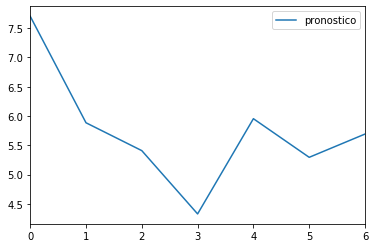

In [25]:
prediccion1SemanaJunio = pd.DataFrame(inverted)
prediccion1SemanaJunio.columns = ['pronostico']
prediccion1SemanaJunio.plot()
prediccion1SemanaJunio.to_csv('pronostico_embeddings_I.csv')

In [26]:
prediccion1SemanaJunio

,pronostico
0,7.701932
1,5.884584
2,5.408941
3,4.329362
4,5.953949
5,5.295027
6,5.692028


A partir de los últimos 7 días de Mayo 2019 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de unidades para la primer semana de Junio.

Para Probar, alterando parámetros del ejercicio:

Variar la cantidad de EPOCHS
Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate.
Cambiar la arquitectura de la Red Neuronal:
Cambiar la cantidad de Neuronas de la capa oculta.
Agregar más capas ocultas
Probar utilizando más de 7 días previos para predecir. O probar con menos días.
Se puede intentar predecir más de 1 día por vez (sin iterar el resultado como hice con la función agregarNuevoValor() )

## Agregamos el resultado en el dataset

In [27]:
i=0
for fila in prediccion1SemanaJunio.pronostico:
    i=i+1
    ultimosDias.loc['2019-06-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

7.701932143348003
5.884583969243468
5.408940590585001
4.329361754307086
5.95394946806321
5.295026820338263
5.6920280720283065


C:\Users\hmarq\Anaconda3\envs\Pippo\lib\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,unidades,weekday,month
fecha,,,
2019-05-24 00:00:00,105.000000,4.000000,5.000000
2019-05-25 00:00:00,59.000000,5.000000,5.000000
2019-05-26 00:00:00,74.000000,6.000000,5.000000
2019-05-27 00:00:00,37.000000,0.000000,5.000000
2019-05-28 00:00:00,1.000000,1.000000,5.000000
2019-05-29 00:00:00,1.000000,2.000000,5.000000
2019-05-31 00:00:00,1.000000,4.000000,5.000000
2019-06-01 00:00:00,7.701932,7.701932,7.701932
2019-06-02 00:00:00,5.884584,5.884584,5.884584
